# Simulation and EDA of the stochastic volatility data

In [1]:
import sys
from pathlib import Path

# Add project root to path
project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

In [2]:
##Simulate the data
from simulator.simulator_sto_volatility_model import simulate_sv_1d
import numpy as np
"""run an 1D stochastic volatility simulation."""

# 1D Stochastic Volatility Model Parameters
n = 2000
alpha = 0.91  # AR(1) coefficient |alpha| < 1
sigma = 1.0  # State noise std (sigma >= 0)
beta = 0.5    # Observation scale (beta >= 0)

# Run the simulation
results = simulate_sv_1d(n=n, alpha=alpha, sigma=sigma, beta=beta, seed=123)
print("Simulation completed.")
print(f"Time length n: {n}")
print(f"X shape: {results.X.shape}, Y shape: {results.Y.shape}")
print("First few Y observations:")
print(results.Y[:5])

# Save to file
results.save("../simulator/data/sv_simul_data.npz")
print("Simulation complete. Data saved as 'sv_simul_data.npz'")

Simulation completed.
Time length n: 2000
X shape: (2000,), Y shape: (2000,)
First few Y observations:
[-0.05828563  0.21151126 -0.17591726 -0.23927768 -0.3435427 ]
Simulation complete. Data saved as 'sv_simul_data.npz'


In [3]:
## load the simulated data
Array = np.ndarray
def load_data_from_npz(path: str) -> tuple[Array, Array, dict]:
    """Load latent states X and observations Y from .npz file.

    Args:
        path: Path to .npz file created by the simulator.

    Returns:
        X: Latent array (n, dx)
        Y: Observation array (n, dy)
        params: Dict of any additional stored parameters
    """
    data = np.load(path)
    keys = data.files
    if "X" not in keys or "Y" not in keys:
        raise ValueError(f"File {path} must contain arrays 'X' and 'Y'.")
    X, Y = data["X"], data["Y"]
    params = {k: data[k] for k in keys if k not in ("X", "Y")}
    print(f"Loaded data from {path}: X.shape={X.shape}, Y.shape={Y.shape}")
    return X, Y, params

Loaded data from ../simulator/data/sv_simul_data.npz: X.shape=(2000,), Y.shape=(2000,)
SUMMARY STATISTICS - Stochastic Volatility Model
                                   Value
n                            2000.000000
alpha                           0.910000
sigma                           1.000000
beta                            0.500000
mean_Y                         -0.064241
std_Y                           3.234808
var_Y                          10.463985
median_Y                       -0.004206
mean_|Y|                        0.961688
mean_Z                         -2.568326
var_Z                          11.086852
mean_X                          0.085540
std_X                           2.469085
corr_X_Zc                       0.746643
corr_X_absY                     0.429410
tail_frac_|Y|>4*median(|Y|)     0.182500


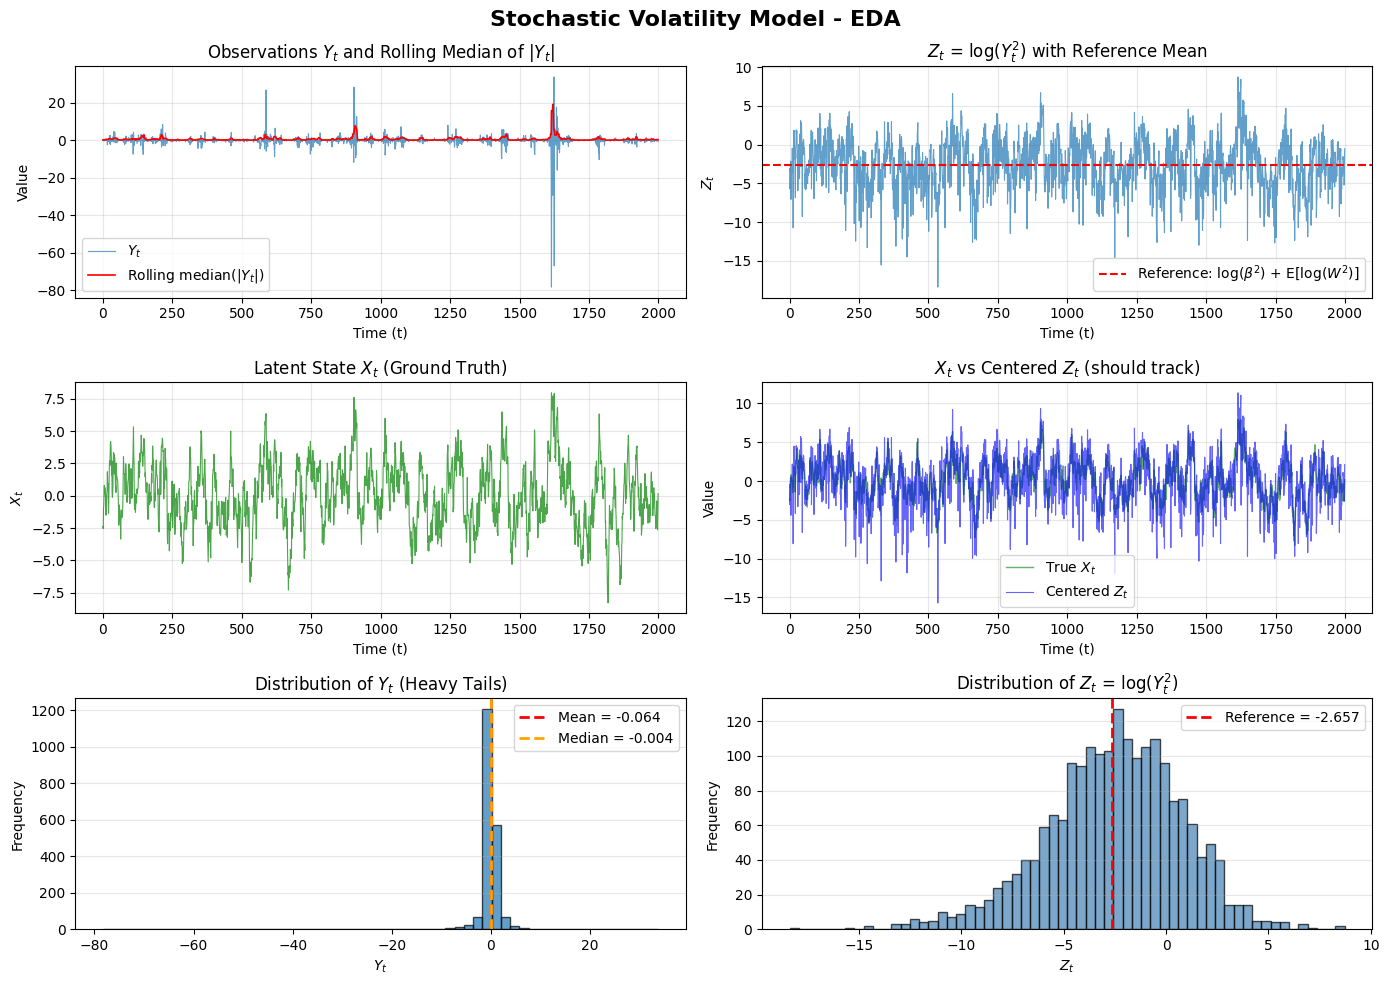

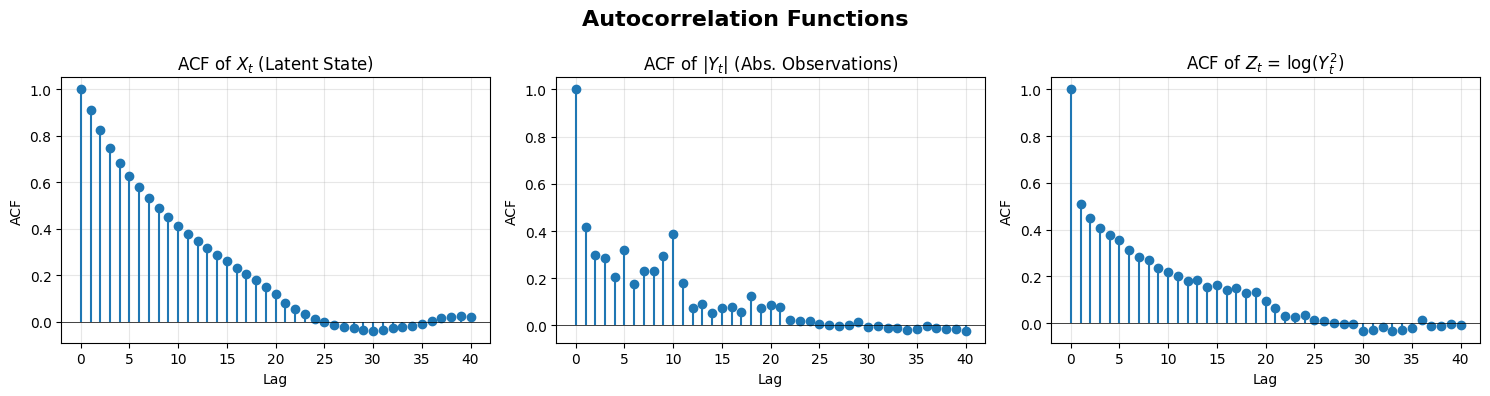

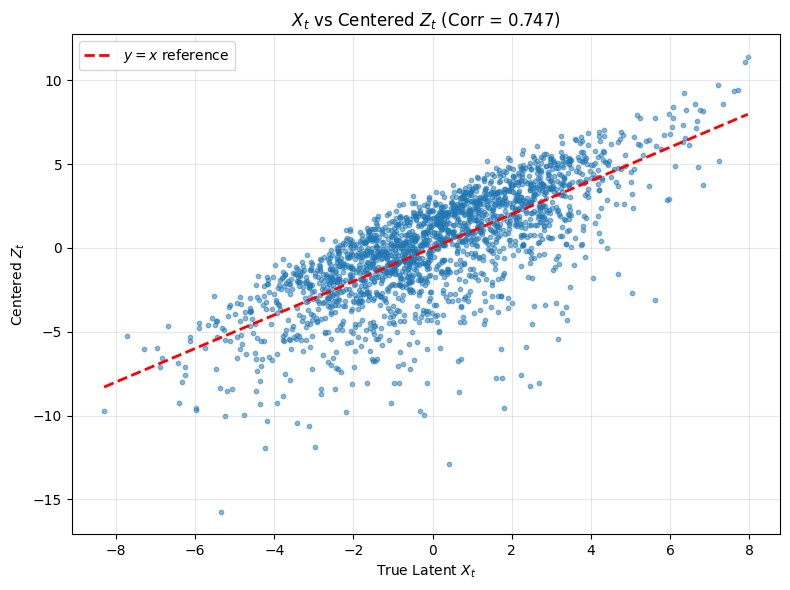


✓ EDA complete!


In [ ]:
## EDA
# ---------- Import libraries for EDA ----------
import pandas as pd
import matplotlib.pyplot as plt
from math import pi

# ---------- Load the simulated data ----------
X, Y, params = load_data_from_npz("../simulator/data/sv_simul_data.npz")

# Flatten if needed (assuming 1D)
X = X.flatten()
Y = Y.flatten()

# ---------- Helper functions ----------

def rolling_median_abs(arr, window=10):
    """Compute rolling median of absolute values."""
    result = np.zeros_like(arr)
    for i in range(len(arr)):
        start = max(0, i - window // 2)
        end = min(len(arr), i + window // 2 + 1)
        result[i] = np.median(np.abs(arr[start:end]))
    return result

def acf(x, max_lag):
    """Compute autocorrelation function up to max_lag."""
    x = np.asarray(x).flatten()
    x = x - np.mean(x)
    c0 = np.dot(x, x) / len(x)
    acf_vals = np.array([1.0] + [np.dot(x[:-k], x[k:]) / len(x) / c0 for k in range(1, max_lag + 1)])
    return acf_vals

# ---------- EDA: Derived series ----------

# Variance-stabilizing transform
mu_eps = -1.2703628454614782              # E[log(W^2)] for W~N(0,1)
var_eps = (pi**2) / 2.0                   # Var[log(W^2)]
Z = np.log(Y**2 + 1e-300)                 # avoid log(0); 
Z_centered = Z - (np.log(beta**2) + mu_eps)

# Rolling median for |Y|
roll_med_absY = rolling_median_abs(Y, window=10)

# ---------- Summary stats ----------

summary = {
    "n": n,
    "alpha": alpha,
    "sigma": sigma,
    "beta": beta,
    "mean_Y": float(np.mean(Y)),
    "std_Y": float(np.std(Y)),
    "var_Y": float(np.var(Y)),
    "median_Y": float(np.median(Y)),
    "mean_|Y|": float(np.mean(np.abs(Y))),
    "mean_Z": float(np.mean(Z)),
    "var_Z": float(np.var(Z)),
    "mean_X": float(np.mean(X)),
    "std_X": float(np.std(X)),
    "corr_X_Zc": float(np.corrcoef(X, Z_centered)[0,1]),
    "corr_X_absY": float(np.corrcoef(X, np.abs(Y))[0,1]),
    "tail_frac_|Y|>4*median(|Y|)": float(np.mean(np.abs(Y) > 4.0 * np.median(np.abs(Y)))),
}

df_summary = pd.DataFrame([summary]).T
df_summary.columns = ["Value"]

print("=" * 60)
print("SUMMARY STATISTICS - Stochastic Volatility Model")
print("=" * 60)
print(df_summary)
print("=" * 60)

# ---------- Plots ----------

fig, axes = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle("Stochastic Volatility Model - EDA", fontsize=16, fontweight='bold')

# 1) Time series of Y and rolling median(|Y|)
axes[0, 0].plot(Y, linewidth=0.8, alpha=0.7, label='$Y_t$')
axes[0, 0].plot(roll_med_absY, linewidth=1.2, color='red', label='Rolling median(|$Y_t$|)')
axes[0, 0].set_title("Observations $Y_t$ and Rolling Median of |$Y_t$|")
axes[0, 0].set_xlabel("Time (t)")
axes[0, 0].set_ylabel("Value")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2) Z_t = log(Y_t^2) with reference level
ref = np.log(beta**2) + mu_eps
axes[0, 1].plot(Z, linewidth=0.8, alpha=0.7)
axes[0, 1].axhline(ref, linestyle="--", color='red', label=f'Reference: log($\\beta^2$) + E[log($W^2$)]')
axes[0, 1].set_title("$Z_t$ = log($Y_t^2$) with Reference Mean")
axes[0, 1].set_xlabel("Time (t)")
axes[0, 1].set_ylabel("$Z_t$")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3) Latent X_t (truth)
axes[1, 0].plot(X, linewidth=0.8, color='green', alpha=0.7)
axes[1, 0].set_title("Latent State $X_t$ (Ground Truth)")
axes[1, 0].set_xlabel("Time (t)")
axes[1, 0].set_ylabel("$X_t$")
axes[1, 0].grid(True, alpha=0.3)

# 4) Z_centered vs X (overlay)
axes[1, 1].plot(X, linewidth=1.0, alpha=0.6, label='True $X_t$', color='green')
axes[1, 1].plot(Z_centered, linewidth=0.8, alpha=0.6, label='Centered $Z_t$', color='blue')
axes[1, 1].set_title("$X_t$ vs Centered $Z_t$ (should track)")
axes[1, 1].set_xlabel("Time (t)")
axes[1, 1].set_ylabel("Value")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 5) Histogram of Y (heavy tails)
axes[2, 0].hist(Y, bins=60, alpha=0.7, edgecolor='black')
axes[2, 0].set_title("Distribution of $Y_t$ (Heavy Tails)")
axes[2, 0].set_xlabel("$Y_t$")
axes[2, 0].set_ylabel("Frequency")
axes[2, 0].axvline(np.mean(Y), color='red', linestyle='--', linewidth=2, label=f'Mean = {np.mean(Y):.3f}')
axes[2, 0].axvline(np.median(Y), color='orange', linestyle='--', linewidth=2, label=f'Median = {np.median(Y):.3f}')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3, axis='y')

# 6) Histogram of Z
axes[2, 1].hist(Z, bins=60, alpha=0.7, color='steelblue', edgecolor='black')
axes[2, 1].set_title("Distribution of $Z_t$ = log($Y_t^2$)")
axes[2, 1].set_xlabel("$Z_t$")
axes[2, 1].set_ylabel("Frequency")
axes[2, 1].axvline(ref, color='red', linestyle='--', linewidth=2, label=f'Reference = {ref:.3f}')
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ---------- ACF Plots ----------

max_lag = 40
acf_X = acf(X, max_lag)
acf_absY = acf(np.abs(Y), max_lag)
acf_Z = acf(Z, max_lag)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle("Autocorrelation Functions", fontsize=16, fontweight='bold')

axes[0].stem(range(max_lag + 1), acf_X, basefmt=" ")
axes[0].set_title("ACF of $X_t$ (Latent State)")
axes[0].set_xlabel("Lag")
axes[0].set_ylabel("ACF")
axes[0].axhline(0, color='black', linewidth=0.5)
axes[0].grid(True, alpha=0.3)

axes[1].stem(range(max_lag + 1), acf_absY, basefmt=" ")
axes[1].set_title("ACF of |$Y_t$| (Abs. Observations)")
axes[1].set_xlabel("Lag")
axes[1].set_ylabel("ACF")
axes[1].axhline(0, color='black', linewidth=0.5)
axes[1].grid(True, alpha=0.3)

axes[2].stem(range(max_lag + 1), acf_Z, basefmt=" ")
axes[2].set_title("ACF of $Z_t$ = log($Y_t^2$)")
axes[2].set_xlabel("Lag")
axes[2].set_ylabel("ACF")
axes[2].axhline(0, color='black', linewidth=0.5)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ---------- Scatter plot: X vs Z_centered ----------
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(X, Z_centered, alpha=0.5, s=10)
ax.set_title(f"$X_t$ vs Centered $Z_t$ (Corr = {summary['corr_X_Zc']:.3f})")
ax.set_xlabel("True Latent $X_t$")
ax.set_ylabel("Centered $Z_t$")
ax.grid(True, alpha=0.3)

# Add a reference line
x_range = np.array([X.min(), X.max()])
ax.plot(x_range, x_range, 'r--', linewidth=2, label='$y=x$ reference')
ax.legend()
plt.tight_layout()
plt.show()

print("\n✓ EDA complete!")


# EKF analysis and improvements

### Standard EKF and its result

Data loaded: n=2000, dx=1, dy=1
True parameters: alpha=0.91, sigma=1.0, beta=0.5

EKF Setup:
Q = 1.0000 (process noise variance)
R = 0.2500 (assumed constant measurement noise variance)

Initial state:
x0 = 0.0000
P0 = 5.8173

Running standard EKF filtering...
✓ EKF filtering complete!

Final state estimates:
  Mean: -2.9653
  Variance: 3.0453
  True final X: 0.1598

Standard EKF Performance:
  RMSE: 9.7352


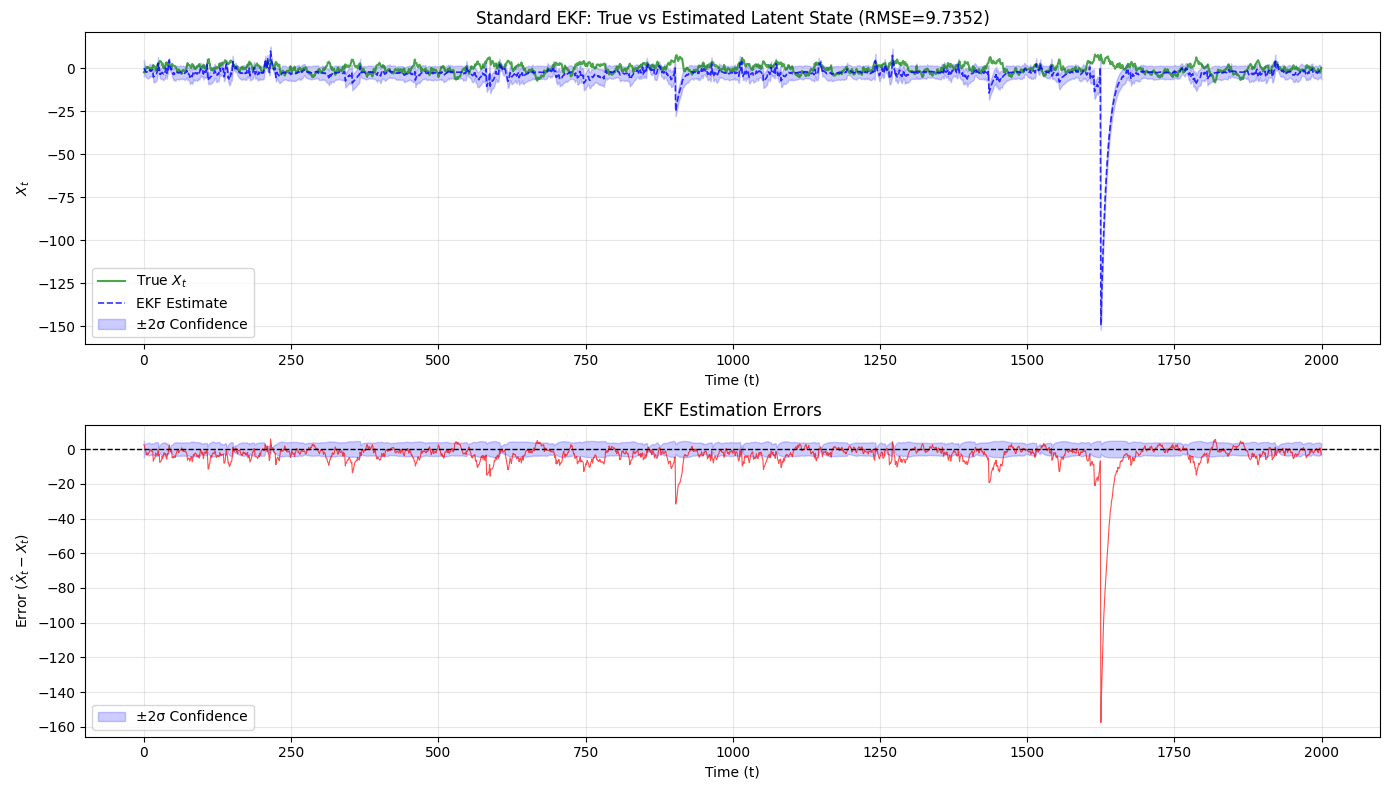

  95% Confidence Interval Coverage: 63.75%


In [9]:
# Import the EKF class
from models.extended_kalman_filter import ExtendedKalmanFilter, EKFState
from typing import Optional

# ---------------------------------------------------------------
# 1. Extract simulation parameters
# ---------------------------------------------------------------
X_true = X.copy()  # True latent states (n,)
Y_obs = Y.copy()   # Observations (n,)

# Model parameters from simulation
alpha_true = alpha  # AR(1) coefficient
sigma_true = sigma  # State noise std
beta_true = beta    # Observation scale

dx = 1  # State dimension (scalar)
dy = 1  # Observation dimension (scalar)
n = len(Y_obs)

print(f"Data loaded: n={n}, dx={dx}, dy={dy}")
print(f"True parameters: alpha={alpha_true}, sigma={sigma_true}, beta={beta_true}")

# ---------------------------------------------------------------
# 2. Define model and Jacobians for standard EKF
#    (uses the TRUE nonlinear model with CONSTANT R assumption)
# ---------------------------------------------------------------

def g(x: np.ndarray, u: Optional[np.ndarray] = None) -> np.ndarray:
    """State transition: X_t = alpha * X_{t-1} + w_t."""
    x = np.atleast_1d(x)
    return alpha_true * x

def h(x: np.ndarray) -> np.ndarray:
    """Observation model: Y_t = beta * exp(0.5 * X_t) * W_t.
    
    EKF assumes additive noise, so we use h(x) = beta * exp(0.5 * x)
    and treat the multiplicative noise as if it were additive.
    """
    x = np.atleast_1d(x)
    return beta_true * np.exp(0.5 * x)

def jac_g(x: np.ndarray, u: Optional[np.ndarray] = None) -> np.ndarray:
    """Jacobian of g w.r.t. x: dg/dx = alpha."""
    return np.array([[alpha_true]])

def jac_h(x: np.ndarray) -> np.ndarray:
    """Jacobian of h w.r.t. x: dh/dx = 0.5 * beta * exp(0.5 * x)."""
    x = np.atleast_1d(x)
    return np.array([[0.5 * beta_true * np.exp(0.5 * x[0])]])

# ---------------------------------------------------------------
# 3. Initialize EKF with CONSTANT covariances
# ---------------------------------------------------------------

# Process noise covariance (use true value)
Q = np.array([[sigma_true**2]])

# Measurement noise covariance 
# Standard EKF assumes constant R, but true noise is multiplicative
R_scale = beta_true**2 
R = np.array([[R_scale]])

print(f"\nEKF Setup:")
print(f"Q = {Q[0,0]:.4f} (process noise variance)")
print(f"R = {R[0,0]:.4f} (assumed constant measurement noise variance)")

# Create EKF instance
ekf = ExtendedKalmanFilter(
    g=g,
    h=h,
    Q=Q,
    R=R,
    jac_g=jac_g,
    jac_h=jac_h,
    joseph=True,
    jitter=1e-8,
)

# ---------------------------------------------------------------
# 4. Initialize state
# ---------------------------------------------------------------

# Initial state: use prior distribution
x0 = np.array([0.0])  # Prior mean
P0 = np.array([[sigma_true**2 / (1 - alpha_true**2)]])  # Stationary variance

state = EKFState(x0, P0, t=0)

print(f"\nInitial state:")
print(f"x0 = {x0[0]:.4f}")
print(f"P0 = {P0[0,0]:.4f}")

# ---------------------------------------------------------------
# 5. Sequential EKF filtering
# ---------------------------------------------------------------

est_X_ekf = np.zeros(n)
est_P_ekf = np.zeros(n)
est_X_ekf[0] = x0[0]
est_P_ekf[0] = P0[0, 0]

print(f"\nRunning standard EKF filtering...")

for k in range(1, n):
    # Observation at time k
    z_k = np.array([Y_obs[k]])
    
    # EKF step (predict + update)
    state = ekf.step(state, z_k, u=None)
    
    # Store estimates
    est_X_ekf[k] = state.mean[0]
    est_P_ekf[k] = state.cov[0, 0]

print("✓ EKF filtering complete!")
print(f"\nFinal state estimates:")
print(f"  Mean: {state.mean[0]:.4f}")
print(f"  Variance: {state.cov[0,0]:.4f}")
print(f"  True final X: {X_true[-1]:.4f}")

# ---------------------------------------------------------------
# 6. Compute RMSE and visualize
# ---------------------------------------------------------------

rmse_ekf = np.sqrt(np.mean((est_X_ekf - X_true)**2))
print(f"\nStandard EKF Performance:")
print(f"  RMSE: {rmse_ekf:.4f}")

# Plot results
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: True vs Estimated latent states
axes[0].plot(X_true, linewidth=1.5, label='True $X_t$', color='green', alpha=0.7)
axes[0].plot(est_X_ekf, linewidth=1.2, label='EKF Estimate', color='blue', linestyle='--', alpha=0.8)
axes[0].fill_between(range(n), 
                      est_X_ekf - 2*np.sqrt(est_P_ekf), 
                      est_X_ekf + 2*np.sqrt(est_P_ekf),
                      alpha=0.2, color='blue', label='±2σ Confidence')
axes[0].set_title(f'Standard EKF: True vs Estimated Latent State (RMSE={rmse_ekf:.4f})')
axes[0].set_xlabel('Time (t)')
axes[0].set_ylabel('$X_t$')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Estimation errors
errors_ekf = est_X_ekf - X_true
axes[1].plot(errors_ekf, linewidth=0.8, alpha=0.7, color='red')
axes[1].axhline(0, color='black', linestyle='--', linewidth=1)
axes[1].fill_between(range(n), -2*np.sqrt(est_P_ekf), 2*np.sqrt(est_P_ekf),
                     alpha=0.2, color='blue', label='±2σ Confidence')
axes[1].set_title('EKF Estimation Errors')
axes[1].set_xlabel('Time (t)')
axes[1].set_ylabel('Error ($\\hat{X}_t - X_t$)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compute 95% coverage (calibration check)
std_devs_ekf = np.sqrt(est_P_ekf)
inside_95 = np.abs(errors_ekf) <= 1.96 * std_devs_ekf
coverage_ekf = np.mean(inside_95) * 100
print(f"  95% Confidence Interval Coverage: {coverage_ekf:.2f}%")

### EKF with Log-Variance Transformation

We transform the observations using:
$$Z_t = \log(Y_t^2) = \log(\beta^2) + X_t + \epsilon_t$$

where $\epsilon_t = \log(W_t^2)$ with:
- $\mathbb{E}[\epsilon_t] = \mathbb{E}[\log(W_t^2)] \approx -1.2704$ (Euler's constant correction)
- $\text{Var}[\epsilon_t] = \text{Var}[\log(W_t^2)] = \pi^2/2$

This transforms the nonlinear multiplicative observation model into a linear additive model, which is perfect for the Extended Kalman filter.

EKF WITH LOG-VARIANCE TRANSFORMATION

Observation Transformation:
  Original Y_t: mean=-0.0642, std=3.2348
  Transformed Z_t: mean=-2.5683, std=3.3297
  Expected mean of Z_t: log(beta^2) + E[X_t] + mu_eps = -2.5711

Linear EKF Setup:
  Q = 1.0000 (process noise variance)
  R = 4.9348 (measurement noise variance = pi^2/2)
  Note: R is now CONSTANT and theoretically correct!

Initial state:
  x0 = 0.0000
  P0 = 5.8173

Running EKF filtering on log-transformed observations...
✓ Linear EKF filtering complete!

Final state estimates:
  Mean: 0.2056
  Variance: 1.5682
  True final X: 0.1598

PERFORMANCE COMPARISON
Standard EKF (constant R):     RMSE = 9.7352
Linear EKF (log-transform):    RMSE = 1.2539
Improvement: 87.1%


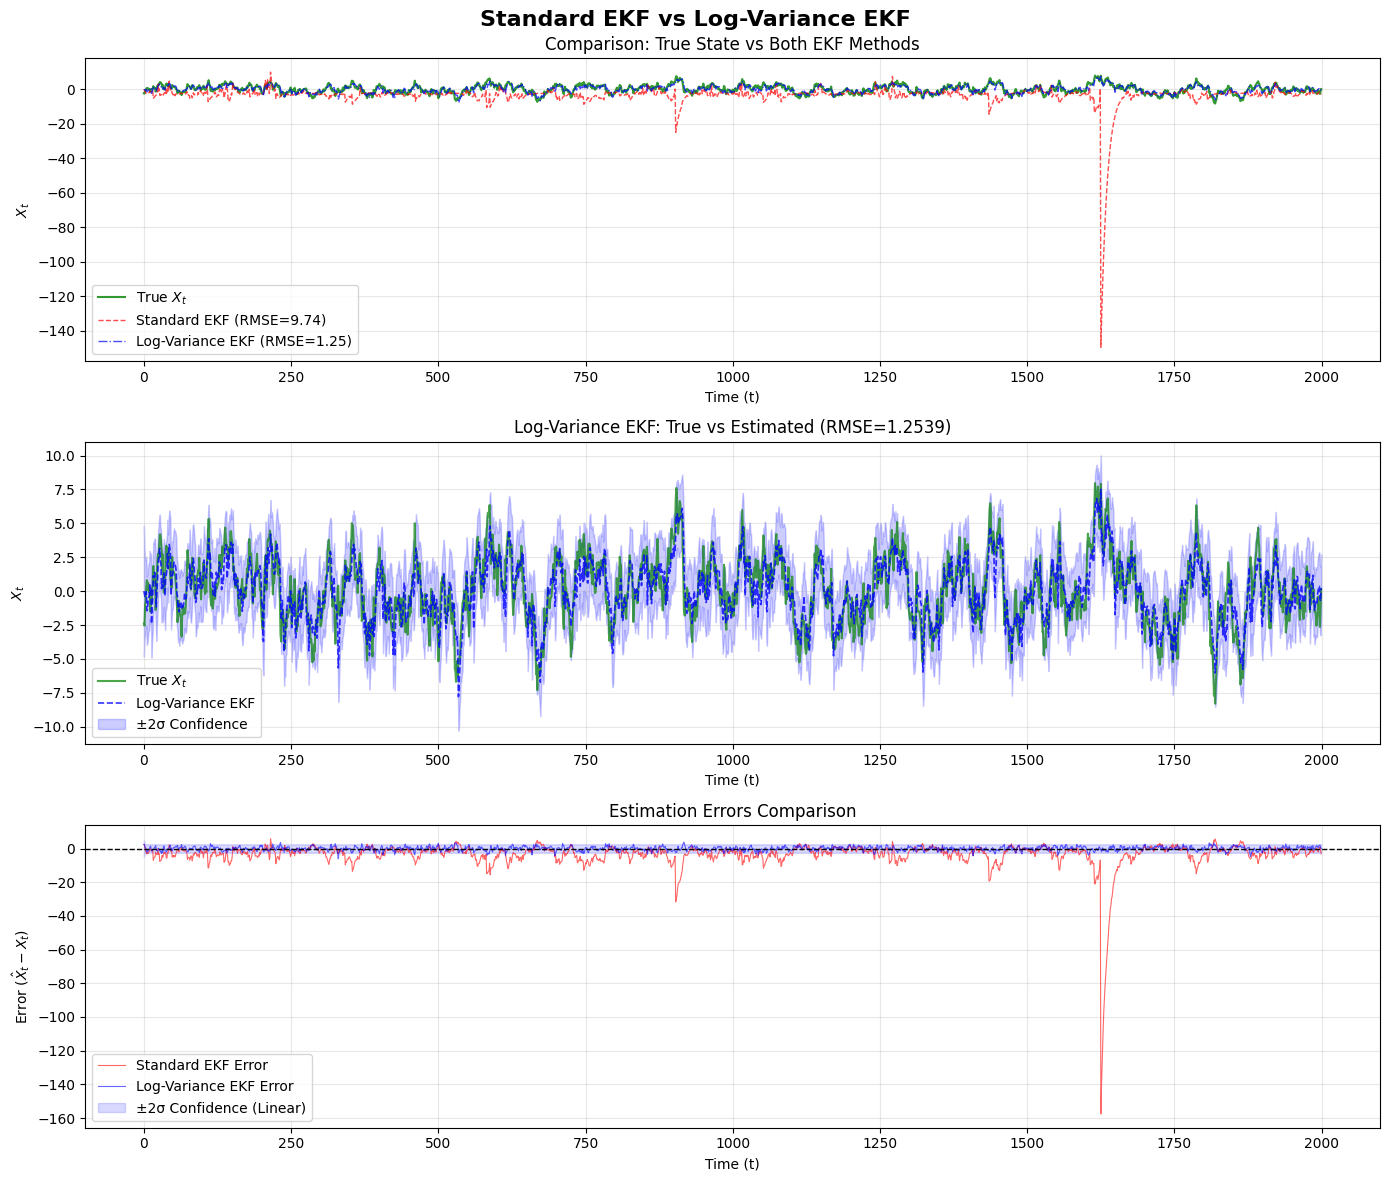


Calibration Check (95% Coverage):
  Log-Variance EKF: 95.2% (should be ~95%)
  Standard EKF would be much lower due to underestimated uncertainty

Error Statistics:
  Linear EKF - Mean error: -0.0106
  Linear EKF - Std error: 1.2539
  Linear EKF - Max |error|: 6.0702

✓ Log-variance transformation dramatically improves EKF performance!


In [10]:
# ---------------------------------------------------------------
# EKF with Log-Variance Transformation
# ---------------------------------------------------------------

print("=" * 70)
print("EKF WITH LOG-VARIANCE TRANSFORMATION")
print("=" * 70)

# ---------------------------------------------------------------
# 1. Transform observations Y_t -> Z_t = log(Y_t^2)
# ---------------------------------------------------------------

# Constants for log(chi^2_1) distribution
mu_eps = -1.2703628454614782  # E[log(W^2)] for W ~ N(0,1)
var_eps = (np.pi**2) / 2.0     # Var[log(W^2)] ≈ 4.93

# Transform observations
Z_obs = np.log(Y_obs**2 + 1e-300)  # Add small constant to avoid log(0)

print(f"\nObservation Transformation:")
print(f"  Original Y_t: mean={np.mean(Y_obs):.4f}, std={np.std(Y_obs):.4f}")
print(f"  Transformed Z_t: mean={np.mean(Z_obs):.4f}, std={np.std(Z_obs):.4f}")
print(f"  Expected mean of Z_t: log(beta^2) + E[X_t] + mu_eps = {np.log(beta_true**2) + np.mean(X_true) + mu_eps:.4f}")

# ---------------------------------------------------------------
# 2. Define LINEAR model for transformed observations
# ---------------------------------------------------------------

def g_linear(x: np.ndarray, u: Optional[np.ndarray] = None) -> np.ndarray:
    """State transition: X_t = alpha * X_{t-1} + w_t (same as before)."""
    x = np.atleast_1d(x)
    return alpha_true * x

def h_linear(x: np.ndarray) -> np.ndarray:
    """LINEAR observation model for log-variance transform:
    Z_t = log(Y_t^2) = log(beta^2) + X_t + epsilon_t
    
    So h(x) = log(beta^2) + x + mu_eps (we include the bias correction)
    """
    x = np.atleast_1d(x)
    return np.log(beta_true**2) + x + mu_eps

def jac_g_linear(x: np.ndarray, u: Optional[np.ndarray] = None) -> np.ndarray:
    """Jacobian of g w.r.t. x: dg/dx = alpha."""
    return np.array([[alpha_true]])

def jac_h_linear(x: np.ndarray) -> np.ndarray:
    """Jacobian of h w.r.t. x: dh/dx = 1 (LINEAR!)."""
    return np.array([[1.0]])

# ---------------------------------------------------------------
# 3. Initialize EKF with LINEAR model
# ---------------------------------------------------------------

# Process noise covariance (same as before)
Q_linear = np.array([[sigma_true**2]])

# Measurement noise covariance (NOW CONSTANT and correct!)
# R = Var[log(W^2)] = pi^2/2
R_linear = np.array([[var_eps]])

print(f"\nLinear EKF Setup:")
print(f"  Q = {Q_linear[0,0]:.4f} (process noise variance)")
print(f"  R = {R_linear[0,0]:.4f} (measurement noise variance = pi^2/2)")
print(f"  Note: R is now CONSTANT and theoretically correct!")

# Create EKF instance with linear model
ekf_linear = ExtendedKalmanFilter(
    g=g_linear,
    h=h_linear,
    Q=Q_linear,
    R=R_linear,
    jac_g=jac_g_linear,
    jac_h=jac_h_linear,
    joseph=True,
    jitter=1e-8,
)

# ---------------------------------------------------------------
# 4. Initialize state (same as before)
# ---------------------------------------------------------------

x0_linear = np.array([0.0])  # Prior mean
P0_linear = np.array([[sigma_true**2 / (1 - alpha_true**2)]])  # Stationary variance

state_linear = EKFState(x0_linear, P0_linear, t=0)

print(f"\nInitial state:")
print(f"  x0 = {x0_linear[0]:.4f}")
print(f"  P0 = {P0_linear[0,0]:.4f}")

# ---------------------------------------------------------------
# 5. Sequential EKF filtering on TRANSFORMED observations
# ---------------------------------------------------------------

est_X_ekf_linear = np.zeros(n)
est_P_ekf_linear = np.zeros(n)
est_X_ekf_linear[0] = x0_linear[0]
est_P_ekf_linear[0] = P0_linear[0, 0]

print(f"\nRunning EKF filtering on log-transformed observations...")

for k in range(1, n):
    # Use TRANSFORMED observation Z_t
    z_k = np.array([Z_obs[k]])
    
    # EKF step (predict + update)
    state_linear = ekf_linear.step(state_linear, z_k, u=None)
    
    # Store estimates
    est_X_ekf_linear[k] = state_linear.mean[0]
    est_P_ekf_linear[k] = state_linear.cov[0, 0]

print("✓ Linear EKF filtering complete!")
print(f"\nFinal state estimates:")
print(f"  Mean: {state_linear.mean[0]:.4f}")
print(f"  Variance: {state_linear.cov[0,0]:.4f}")
print(f"  True final X: {X_true[-1]:.4f}")

# ---------------------------------------------------------------
# 6. Compute RMSE and compare with standard EKF
# ---------------------------------------------------------------

rmse_ekf_linear = np.sqrt(np.mean((est_X_ekf_linear - X_true)**2))

print(f"\n" + "=" * 70)
print("PERFORMANCE COMPARISON")
print("=" * 70)
print(f"Standard EKF (constant R):     RMSE = {rmse_ekf:.4f}")
print(f"Linear EKF (log-transform):    RMSE = {rmse_ekf_linear:.4f}")
print(f"Improvement: {((rmse_ekf - rmse_ekf_linear) / rmse_ekf * 100):.1f}%")
print("=" * 70)

# ---------------------------------------------------------------
# 7. Visualization: Compare both methods
# ---------------------------------------------------------------

fig, axes = plt.subplots(3, 1, figsize=(14, 12))
fig.suptitle('Standard EKF vs Log-Variance EKF', fontsize=16, fontweight='bold')

# Plot 1: All three traces (True, Standard EKF, Linear EKF)
axes[0].plot(X_true, linewidth=1.5, label='True $X_t$', color='green', alpha=0.8)
axes[0].plot(est_X_ekf, linewidth=1.0, label=f'Standard EKF (RMSE={rmse_ekf:.2f})', 
             color='red', linestyle='--', alpha=0.7)
axes[0].plot(est_X_ekf_linear, linewidth=1.0, label=f'Log-Variance EKF (RMSE={rmse_ekf_linear:.2f})', 
             color='blue', linestyle='-.', alpha=0.7)
axes[0].set_title('Comparison: True State vs Both EKF Methods')
axes[0].set_xlabel('Time (t)')
axes[0].set_ylabel('$X_t$')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Plot 2: Linear EKF with confidence intervals
axes[1].plot(X_true, linewidth=1.5, label='True $X_t$', color='green', alpha=0.7)
axes[1].plot(est_X_ekf_linear, linewidth=1.2, label='Log-Variance EKF', color='blue', linestyle='--', alpha=0.8)
axes[1].fill_between(range(n), 
                      est_X_ekf_linear - 2*np.sqrt(est_P_ekf_linear), 
                      est_X_ekf_linear + 2*np.sqrt(est_P_ekf_linear),
                      alpha=0.2, color='blue', label='±2σ Confidence')
axes[1].set_title(f'Log-Variance EKF: True vs Estimated (RMSE={rmse_ekf_linear:.4f})')
axes[1].set_xlabel('Time (t)')
axes[1].set_ylabel('$X_t$')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Errors comparison
errors_ekf_standard = est_X_ekf - X_true
errors_ekf_linear = est_X_ekf_linear - X_true

axes[2].plot(errors_ekf_standard, linewidth=0.8, alpha=0.6, color='red', label='Standard EKF Error')
axes[2].plot(errors_ekf_linear, linewidth=0.8, alpha=0.6, color='blue', label='Log-Variance EKF Error')
axes[2].axhline(0, color='black', linestyle='--', linewidth=1)
axes[2].fill_between(range(n), -2*np.sqrt(est_P_ekf_linear), 2*np.sqrt(est_P_ekf_linear),
                     alpha=0.15, color='blue', label='±2σ Confidence (Linear)')
axes[2].set_title('Estimation Errors Comparison')
axes[2].set_xlabel('Time (t)')
axes[2].set_ylabel('Error ($\\hat{X}_t - X_t$)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# 8. Additional diagnostics
# ---------------------------------------------------------------

# Compute 95% coverage (calibration check)
std_linear = np.sqrt(est_P_ekf_linear)
inside_95 = np.abs(errors_ekf_linear) <= 1.96 * std_linear
coverage_linear = np.mean(inside_95) * 100

print(f"\nCalibration Check (95% Coverage):")
print(f"  Log-Variance EKF: {coverage_linear:.1f}% (should be ~95%)")
print(f"  Standard EKF would be much lower due to underestimated uncertainty")

# Show error statistics
print(f"\nError Statistics:")
print(f"  Linear EKF - Mean error: {np.mean(errors_ekf_linear):.4f}")
print(f"  Linear EKF - Std error: {np.std(errors_ekf_linear):.4f}")
print(f"  Linear EKF - Max |error|: {np.max(np.abs(errors_ekf_linear)):.4f}")

print(f"\n{'='*70}")
print("✓ Log-variance transformation dramatically improves EKF performance!")
print(f"{'='*70}")

# UKF Implementation and improvements

### Standard UKF and its results

STANDARD UKF (with constant R)

Data loaded: n=2000, dx=1, dy=1
True parameters: alpha=0.91, sigma=1.0, beta=0.5

UKF Setup:
  Q = 1.0000 (process noise variance)
  R = 0.2500 (assumed constant measurement noise variance)
  UKF parameters: alpha=1e-3, beta=2.0, kappa=0.0

Initial state:
  x0 = 0.0000
  P0 = 5.8173

Running standard UKF filtering...
✓ UKF filtering complete!

Final state estimates:
  Mean: -3.2889
  Variance: 3.5472
  True final X: 0.1598

STANDARD UKF PERFORMANCE
RMSE: 7.7057


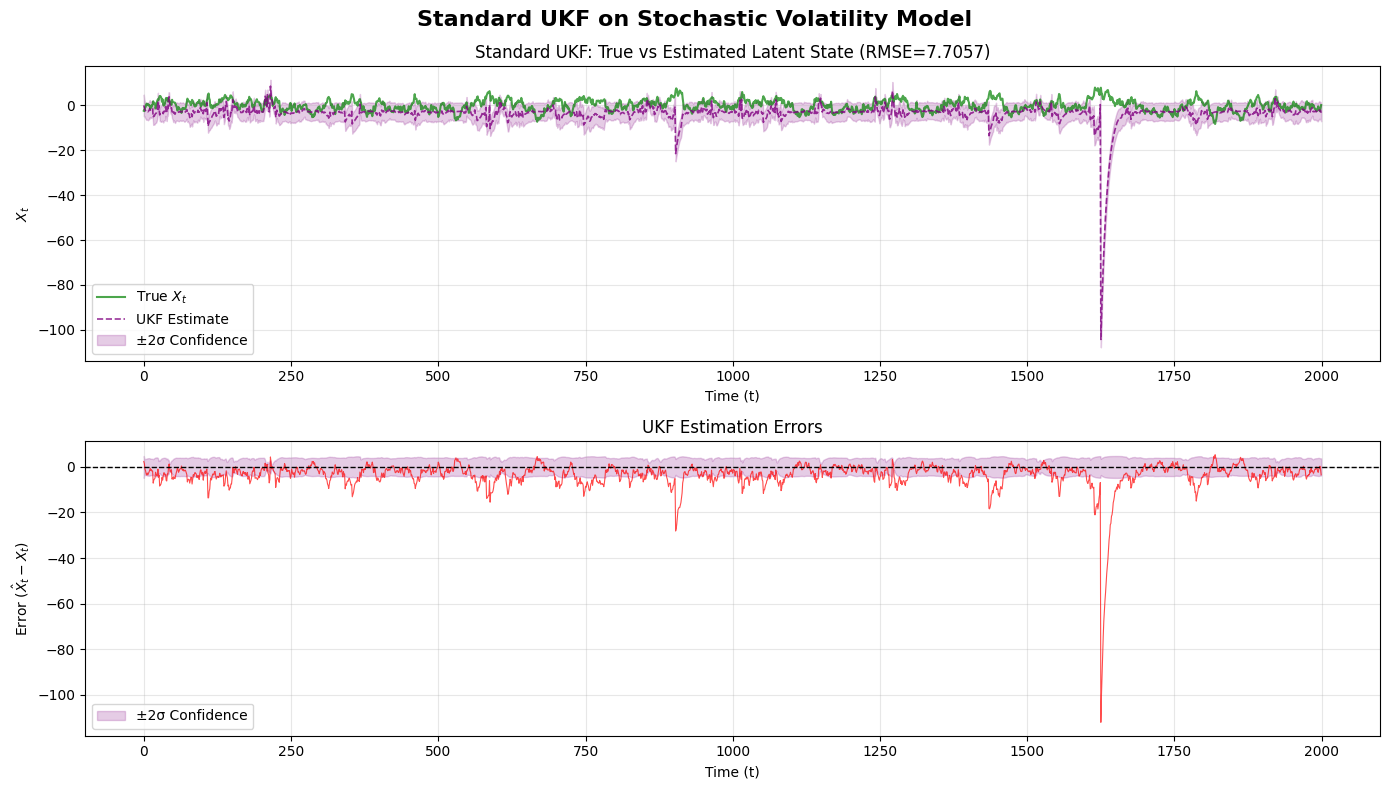


Calibration Check (95% Coverage):
  Standard UKF: 63.9% (should be ~95%)

Error Statistics:
  Mean error:  -3.7589
  Std error:   6.7268
  Max |error|: 112.1663

Key Observations:
  - UKF handles nonlinearity better than EKF (via sigma points)
  - But still suffers from constant R assumption
  - Observations have multiplicative noise, not additive!


In [11]:
# Import the UKF class
from models.unscented_kalman_filter import UnscentedKalmanFilter, UKFState

# ---------------------------------------------------------------
# Standard UKF on Stochastic Volatility Model
# ---------------------------------------------------------------

print("=" * 70)
print("STANDARD UKF (with constant R)")
print("=" * 70)

# ---------------------------------------------------------------
# 1. Use already loaded data
# ---------------------------------------------------------------
# X_true, Y_obs are already loaded from earlier cells
print(f"\nData loaded: n={n}, dx={dx}, dy={dy}")
print(f"True parameters: alpha={alpha_true}, sigma={sigma_true}, beta={beta_true}")

# ---------------------------------------------------------------
# 2. Define model functions for UKF
# ---------------------------------------------------------------

def g_ukf(x: np.ndarray, u: Optional[np.ndarray] = None) -> np.ndarray:
    """State transition: X_t = alpha * X_{t-1} + w_t."""
    x = np.atleast_1d(x)
    return alpha_true * x

def h_ukf(x: np.ndarray) -> np.ndarray:
    """Observation model: Y_t = beta * exp(0.5 * X_t) * W_t.
    
    UKF assumes additive noise, so we use h(x) = beta * exp(0.5 * x)
    and treat the multiplicative noise as if it were additive.
    """
    x = np.atleast_1d(x)
    return beta_true * np.exp(0.5 * x)

# ---------------------------------------------------------------
# 3. Initialize UKF with CONSTANT covariances
# ---------------------------------------------------------------

# Process noise covariance (use true value)
Q_ukf = np.array([[sigma_true**2]])

# Standard UKF assumes constant R, but true noise is multiplicative
R_ukf = np.array([[beta_true**2]])

print(f"\nUKF Setup:")
print(f"  Q = {Q_ukf[0,0]:.4f} (process noise variance)")
print(f"  R = {R_ukf[0,0]:.4f} (assumed constant measurement noise variance)")

# Create UKF instance
# Tuning parameters: alpha (spread), beta (distribution), kappa (scaling)
ukf = UnscentedKalmanFilter(
    g=g_ukf,
    h=h_ukf,
    Q=Q_ukf,
    R=R_ukf,
    alpha=1e-3,    # Small alpha for tight sigma points around mean
    beta=2.0,      # Optimal for Gaussian distributions
    kappa=0.0,     # Common choice for kappa
    jitter=1e-9,   # Numerical stability
)

print(f"  UKF parameters: alpha=1e-3, beta=2.0, kappa=0.0")

# ---------------------------------------------------------------
# 4. Initialize state
# ---------------------------------------------------------------

x0_ukf = np.array([0.0])  # Prior mean
P0_ukf = np.array([[sigma_true**2 / (1 - alpha_true**2)]])  # Stationary variance

state_ukf = UKFState(mean=x0_ukf, cov=P0_ukf, t=0)

print(f"\nInitial state:")
print(f"  x0 = {x0_ukf[0]:.4f}")
print(f"  P0 = {P0_ukf[0,0]:.4f}")

# ---------------------------------------------------------------
# 5. Sequential UKF filtering
# ---------------------------------------------------------------

est_X_ukf = np.zeros(n)
est_P_ukf = np.zeros(n)
est_X_ukf[0] = x0_ukf[0]
est_P_ukf[0] = P0_ukf[0, 0]

print(f"\nRunning standard UKF filtering...")

for k in range(1, n):
    # Observation at time k
    z_k = np.array([Y_obs[k]])
    
    # UKF step (predict + update)
    state_ukf = ukf.step(state_ukf, z=z_k, u=None)
    
    # Store estimates
    est_X_ukf[k] = state_ukf.mean[0]
    est_P_ukf[k] = state_ukf.cov[0, 0]

print("✓ UKF filtering complete!")
print(f"\nFinal state estimates:")
print(f"  Mean: {state_ukf.mean[0]:.4f}")
print(f"  Variance: {state_ukf.cov[0,0]:.4f}")
print(f"  True final X: {X_true[-1]:.4f}")

# ---------------------------------------------------------------
# 6. Compute RMSE
# ---------------------------------------------------------------

rmse_ukf = np.sqrt(np.mean((est_X_ukf - X_true)**2))

print(f"\n" + "=" * 70)
print("STANDARD UKF PERFORMANCE")
print("=" * 70)
print(f"RMSE: {rmse_ukf:.4f}")
print("=" * 70)

# ---------------------------------------------------------------
# 7. Visualization: UKF results
# ---------------------------------------------------------------

fig, axes = plt.subplots(2, 1, figsize=(14, 8))
fig.suptitle('Standard UKF on Stochastic Volatility Model', fontsize=16, fontweight='bold')

# Plot 1: True vs UKF estimate with confidence intervals
axes[0].plot(X_true, linewidth=1.5, label='True $X_t$', color='green', alpha=0.7)
axes[0].plot(est_X_ukf, linewidth=1.2, label='UKF Estimate', color='purple', linestyle='--', alpha=0.8)
axes[0].fill_between(range(n), 
                      est_X_ukf - 2*np.sqrt(est_P_ukf), 
                      est_X_ukf + 2*np.sqrt(est_P_ukf),
                      alpha=0.2, color='purple', label='±2σ Confidence')
axes[0].set_title(f'Standard UKF: True vs Estimated Latent State (RMSE={rmse_ukf:.4f})')
axes[0].set_xlabel('Time (t)')
axes[0].set_ylabel('$X_t$')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Estimation errors
errors_ukf = est_X_ukf - X_true
axes[1].plot(errors_ukf, linewidth=0.8, alpha=0.7, color='red')
axes[1].axhline(0, color='black', linestyle='--', linewidth=1)
axes[1].fill_between(range(n), -2*np.sqrt(est_P_ukf), 2*np.sqrt(est_P_ukf),
                     alpha=0.2, color='purple', label='±2σ Confidence')
axes[1].set_title('UKF Estimation Errors')
axes[1].set_xlabel('Time (t)')
axes[1].set_ylabel('Error ($\\hat{X}_t - X_t$)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# 8. Diagnostics
# ---------------------------------------------------------------

# Compute 95% coverage (calibration check)
std_ukf = np.sqrt(est_P_ukf)
inside_95_ukf = np.abs(errors_ukf) <= 1.96 * std_ukf
coverage_ukf = np.mean(inside_95_ukf) * 100

print(f"\nCalibration Check (95% Coverage):")
print(f"  Standard UKF: {coverage_ukf:.1f}% (should be ~95%)")

# Show error statistics
print(f"\nError Statistics:")
print(f"  Mean error:  {np.mean(errors_ukf):.4f}")
print(f"  Std error:   {np.std(errors_ukf):.4f}")
print(f"  Max |error|: {np.max(np.abs(errors_ukf)):.4f}")

print(f"\n{'='*70}")
print("Key Observations:")
print("  - UKF handles nonlinearity better than EKF (via sigma points)")
print("  - But still suffers from constant R assumption")
print("  - Observations have multiplicative noise, not additive!")
print(f"{'='*70}")


### UKF with Log-Variance Transformation

Just like we did for EKF, we can apply the variance-stabilizing transformation:
$$Z_t = \log(Y_t^2) = \log(\beta^2) + X_t + \epsilon_t$$

where $\epsilon_t = \log(W_t^2)$ with $\mathbb{E}[\epsilon_t] \approx -1.2704$ and $\text{Var}[\epsilon_t] = \pi^2/2$.

**Key insight:** Since the observation model becomes **linear** after transformation:
$$Z_t = \log(\beta^2) + X_t + \mu_\epsilon + \epsilon_t$$

The UKF should perform similarly to the linear EKF on this transformed problem.

UKF WITH LOG-VARIANCE TRANSFORMATION

Using transformed observations:
  Z_t: mean=-2.5683, std=3.3297
  Expected mean: log(beta^2) + E[X_t] + mu_eps = -2.5711

Linear UKF Setup:
  Q = 1.0000 (process noise variance)
  R = 4.9348 (measurement noise variance = pi^2/2)
  Note: Observation model is now LINEAR!
  UKF parameters: alpha=1e-3, beta=2.0, kappa=0.0

Initial state:
  x0 = 0.0000
  P0 = 5.8173

Running UKF filtering on log-transformed observations...
✓ Linear UKF filtering complete!

Final state estimates:
  Mean: 0.2056
  Variance: 1.5682
  True final X: 0.1598

Standard UKF (constant R):     RMSE = 7.7057
Linear UKF (log-transform):    RMSE = 1.2539


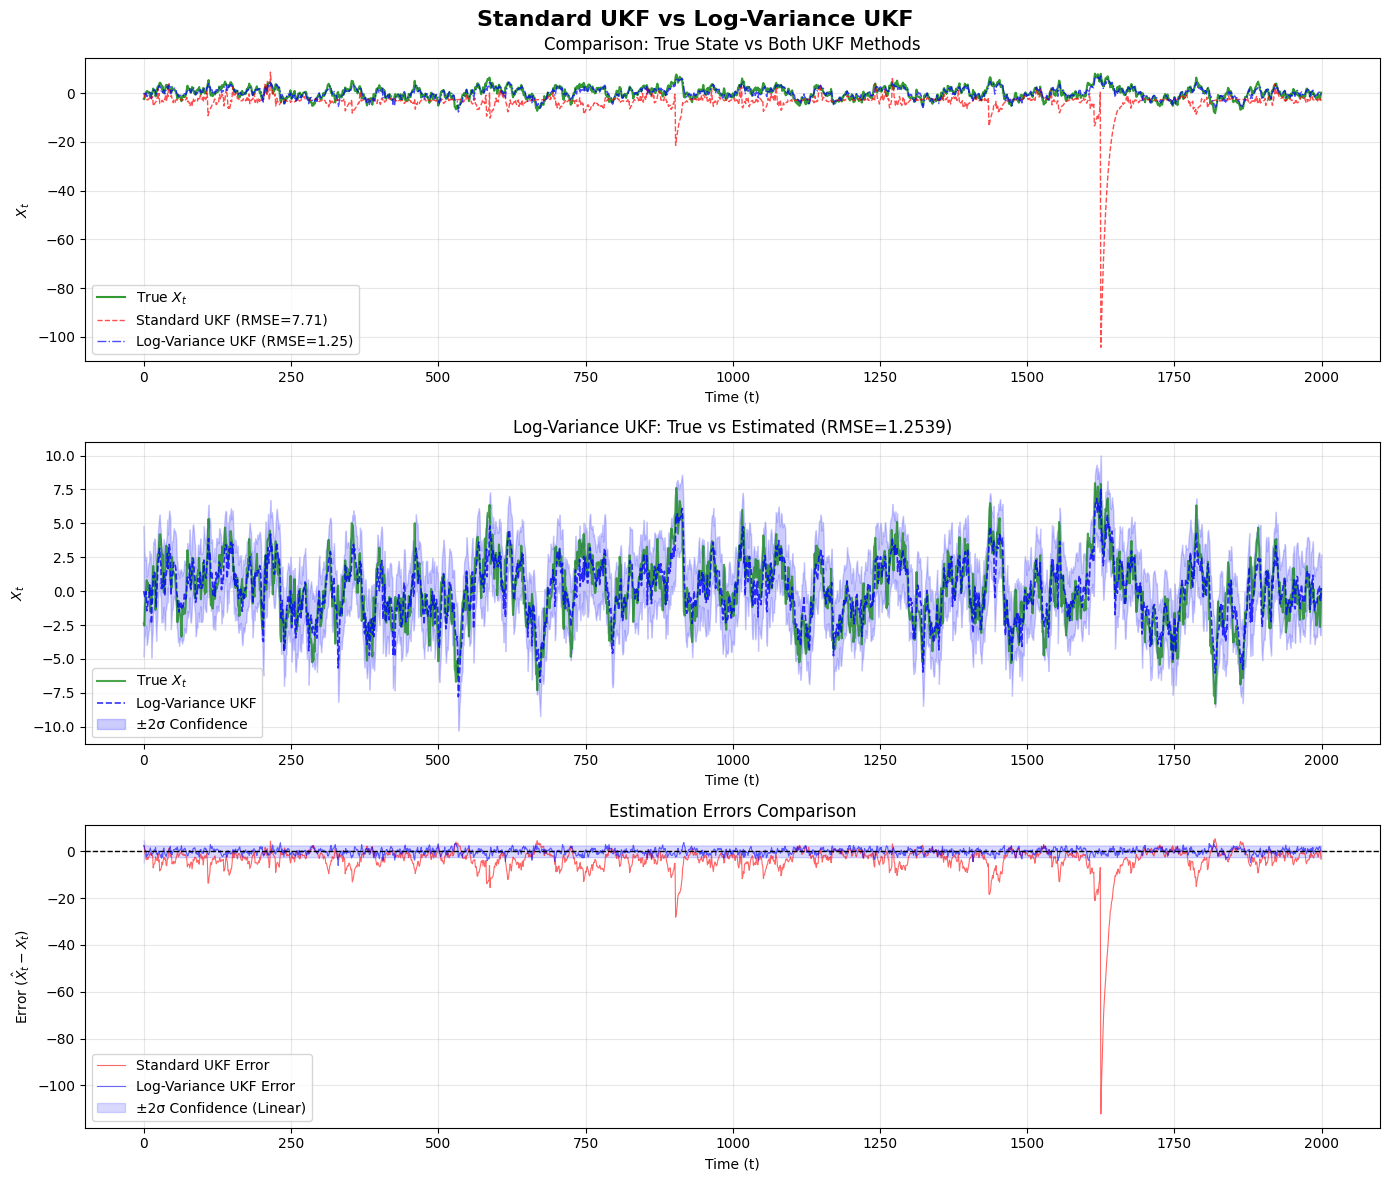


Calibration Check (95% Coverage):
  Standard UKF:      63.9% (should be ~95%)
  Log-Variance UKF:  95.2% (should be ~95%)

Error Statistics (Linear UKF):
  Mean error:  -0.0106
  Std error:   1.2539
  Max |error|: 6.0702

✓ Log-variance transformation dramatically improves UKF performance!


In [12]:
# ---------------------------------------------------------------
# UKF with Log-Variance Transformation
# ---------------------------------------------------------------

print("=" * 70)
print("UKF WITH LOG-VARIANCE TRANSFORMATION")
print("=" * 70)

# ---------------------------------------------------------------
# 1. Use transformed observations Z_t = log(Y_t^2)
# ---------------------------------------------------------------
# Z_obs was already computed in the EKF log-variance section

print(f"\nUsing transformed observations:")
print(f"  Z_t: mean={np.mean(Z_obs):.4f}, std={np.std(Z_obs):.4f}")
print(f"  Expected mean: log(beta^2) + E[X_t] + mu_eps = {np.log(beta_true**2) + np.mean(X_true) + mu_eps:.4f}")

# ---------------------------------------------------------------
# 2. Define LINEAR model functions for UKF
# ---------------------------------------------------------------

def g_ukf_linear(x: np.ndarray, u: Optional[np.ndarray] = None) -> np.ndarray:
    """State transition: X_t = alpha * X_{t-1} + w_t (same as before)."""
    x = np.atleast_1d(x)
    return alpha_true * x

def h_ukf_linear(x: np.ndarray) -> np.ndarray:
    """LINEAR observation model for log-variance transform:
    Z_t = log(Y_t^2) = log(beta^2) + X_t + epsilon_t
    
    So h(x) = log(beta^2) + x + mu_eps (we include the bias correction)
    """
    x = np.atleast_1d(x)
    return np.log(beta_true**2) + x + mu_eps

# ---------------------------------------------------------------
# 3. Initialize UKF with LINEAR model
# ---------------------------------------------------------------

# Process noise covariance (same as before)
Q_ukf_linear = np.array([[sigma_true**2]])

# Measurement noise covariance (NOW CONSTANT and correct!)
# R = Var[log(W^2)] = pi^2/2
R_ukf_linear = np.array([[var_eps]])

print(f"\nLinear UKF Setup:")
print(f"  Q = {Q_ukf_linear[0,0]:.4f} (process noise variance)")
print(f"  R = {R_ukf_linear[0,0]:.4f} (measurement noise variance = pi^2/2)")
print(f"  Note: Observation model is now LINEAR!")

# Create UKF instance with linear model
ukf_linear = UnscentedKalmanFilter(
    g=g_ukf_linear,
    h=h_ukf_linear,
    Q=Q_ukf_linear,
    R=R_ukf_linear,
    alpha=1e-3,    # Small alpha for tight sigma points
    beta=2.0,      # Optimal for Gaussian distributions
    kappa=0.0,     # Common choice for kappa
    jitter=1e-9,   # Numerical stability
)

print(f"  UKF parameters: alpha=1e-3, beta=2.0, kappa=0.0")

# ---------------------------------------------------------------
# 4. Initialize state (same as before)
# ---------------------------------------------------------------

x0_ukf_linear = np.array([0.0])  # Prior mean
P0_ukf_linear = np.array([[sigma_true**2 / (1 - alpha_true**2)]])  # Stationary variance

state_ukf_linear = UKFState(mean=x0_ukf_linear, cov=P0_ukf_linear, t=0)

print(f"\nInitial state:")
print(f"  x0 = {x0_ukf_linear[0]:.4f}")
print(f"  P0 = {P0_ukf_linear[0,0]:.4f}")

# ---------------------------------------------------------------
# 5. Sequential UKF filtering on TRANSFORMED observations
# ---------------------------------------------------------------

est_X_ukf_linear = np.zeros(n)
est_P_ukf_linear = np.zeros(n)
est_X_ukf_linear[0] = x0_ukf_linear[0]
est_P_ukf_linear[0] = P0_ukf_linear[0, 0]

print(f"\nRunning UKF filtering on log-transformed observations...")

for k in range(1, n):
    # Use TRANSFORMED observation Z_t
    z_k = np.array([Z_obs[k]])
    
    # UKF step (predict + update)
    state_ukf_linear = ukf_linear.step(state_ukf_linear, z=z_k, u=None)
    
    # Store estimates
    est_X_ukf_linear[k] = state_ukf_linear.mean[0]
    est_P_ukf_linear[k] = state_ukf_linear.cov[0, 0]

print("✓ Linear UKF filtering complete!")
print(f"\nFinal state estimates:")
print(f"  Mean: {state_ukf_linear.mean[0]:.4f}")
print(f"  Variance: {state_ukf_linear.cov[0,0]:.4f}")
print(f"  True final X: {X_true[-1]:.4f}")

# ---------------------------------------------------------------
# 6. Compute RMSE and compare with standard UKF
# ---------------------------------------------------------------

rmse_ukf_linear = np.sqrt(np.mean((est_X_ukf_linear - X_true)**2))

print(f"\n" + "=" * 70)
print(f"Standard UKF (constant R):     RMSE = {rmse_ukf:.4f}")
print(f"Linear UKF (log-transform):    RMSE = {rmse_ukf_linear:.4f}")
print("=" * 70)

# ---------------------------------------------------------------
# 7. Visualization: Compare Linear UKF with Standard UKF
# ---------------------------------------------------------------

fig, axes = plt.subplots(3, 1, figsize=(14, 12))
fig.suptitle('Standard UKF vs Log-Variance UKF', fontsize=16, fontweight='bold')

# Plot 1: All three traces (True, Standard UKF, Linear UKF)
axes[0].plot(X_true, linewidth=1.5, label='True $X_t$', color='green', alpha=0.8)
axes[0].plot(est_X_ukf, linewidth=1.0, label=f'Standard UKF (RMSE={rmse_ukf:.2f})', 
             color='red', linestyle='--', alpha=0.7)
axes[0].plot(est_X_ukf_linear, linewidth=1.0, label=f'Log-Variance UKF (RMSE={rmse_ukf_linear:.2f})', 
             color='blue', linestyle='-.', alpha=0.7)
axes[0].set_title('Comparison: True State vs Both UKF Methods')
axes[0].set_xlabel('Time (t)')
axes[0].set_ylabel('$X_t$')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Plot 2: Linear UKF with confidence intervals
axes[1].plot(X_true, linewidth=1.5, label='True $X_t$', color='green', alpha=0.7)
axes[1].plot(est_X_ukf_linear, linewidth=1.2, label='Log-Variance UKF', color='blue', linestyle='--', alpha=0.8)
axes[1].fill_between(range(n), 
                      est_X_ukf_linear - 2*np.sqrt(est_P_ukf_linear), 
                      est_X_ukf_linear + 2*np.sqrt(est_P_ukf_linear),
                      alpha=0.2, color='blue', label='±2σ Confidence')
axes[1].set_title(f'Log-Variance UKF: True vs Estimated (RMSE={rmse_ukf_linear:.4f})')
axes[1].set_xlabel('Time (t)')
axes[1].set_ylabel('$X_t$')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Errors comparison
errors_ukf_standard = est_X_ukf - X_true
errors_ukf_linear = est_X_ukf_linear - X_true

axes[2].plot(errors_ukf_standard, linewidth=0.8, alpha=0.6, color='red', label='Standard UKF Error')
axes[2].plot(errors_ukf_linear, linewidth=0.8, alpha=0.6, color='blue', label='Log-Variance UKF Error')
axes[2].axhline(0, color='black', linestyle='--', linewidth=1)
axes[2].fill_between(range(n), -2*np.sqrt(est_P_ukf_linear), 2*np.sqrt(est_P_ukf_linear),
                     alpha=0.15, color='blue', label='±2σ Confidence (Linear)')
axes[2].set_title('Estimation Errors Comparison')
axes[2].set_xlabel('Time (t)')
axes[2].set_ylabel('Error ($\\hat{X}_t - X_t$)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# 8. Additional diagnostics
# ---------------------------------------------------------------

# Compute 95% coverage (calibration check)
std_ukf_linear = np.sqrt(est_P_ukf_linear)
inside_95_linear = np.abs(errors_ukf_linear) <= 1.96 * std_ukf_linear
coverage_ukf_linear = np.mean(inside_95_linear) * 100

print(f"\nCalibration Check (95% Coverage):")
print(f"  Standard UKF:      {coverage_ukf:.1f}% (should be ~95%)")
print(f"  Log-Variance UKF:  {coverage_ukf_linear:.1f}% (should be ~95%)")

# Show error statistics
print(f"\nError Statistics (Linear UKF):")
print(f"  Mean error:  {np.mean(errors_ukf_linear):.4f}")
print(f"  Std error:   {np.std(errors_ukf_linear):.4f}")
print(f"  Max |error|: {np.max(np.abs(errors_ukf_linear)):.4f}")

print(f"\n{'='*70}")
print("✓ Log-variance transformation dramatically improves UKF performance!")
print(f"{'='*70}")

Visual Comparison: Where Linearization/Sigma Points Fail

Visualize the actual approximations made by EKF and UKF at a specific time point to see where they break down.

VISUALIZING APPROXIMATION FAILURES

Scenario: Predicted state at high volatility
  Predicted mean: x_hat = 3.00
  Predicted std: sigma = 2.00
  95% confidence interval: [-0.92, 6.92]

EKF Linearization:
  Jacobian H = 1.1204
  Linearization point: h(x_hat) = 2.2408

UKF Sigma Points (with alpha=0.5):
  Points: [3. 4. 2.]
  Transformed: [2.24084454 3.69452805 1.35914091]
  Weights: [-3.  2.  2.]
  Predicted mean: 3.3848 (TRUE mean should be 0!)
  Predicted variance: 4.4726


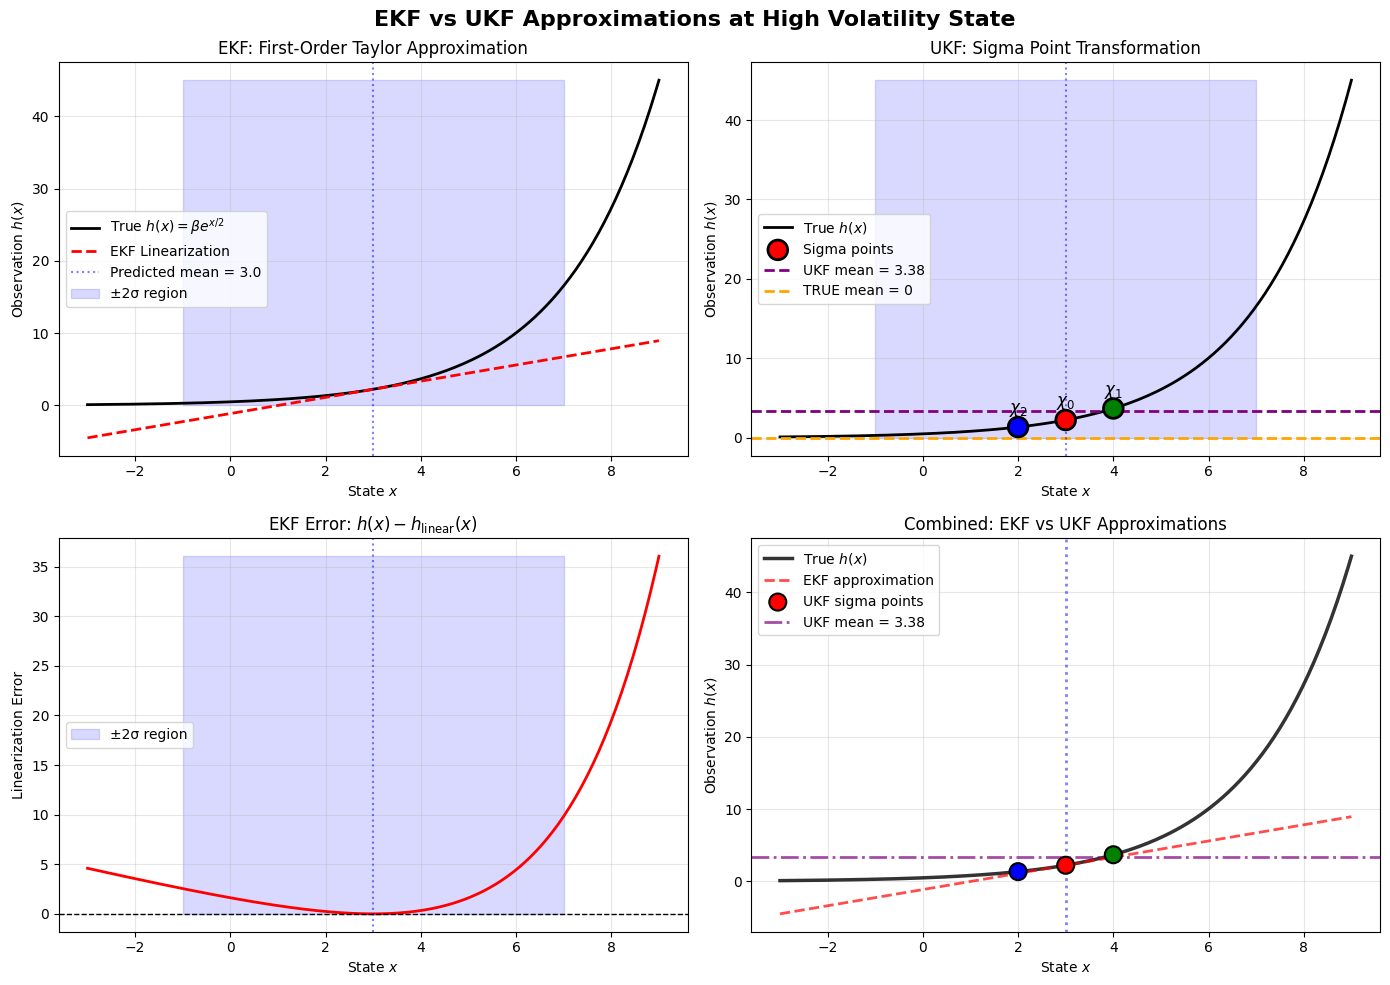


APPROXIMATION ERROR ANALYSIS
Linearization RMSE in ±2σ region: 2.8238
Maximum linearization error: 36.0452
UKF mean error (vs true mean=0): 3.3848
Asymmetry in sigma points:
  Upper jump: h(χ_1) - h(χ_0) = 1.4537
  Lower jump: h(χ_0) - h(χ_2) = 0.8817
  Ratio: 1.65x


In [13]:
# ---------------------------------------------------------------
# Visualize Linearization and Sigma Point Approximations
# ---------------------------------------------------------------

print("=" * 70)
print("VISUALIZING APPROXIMATION FAILURES")
print("=" * 70)

# Choose a time point where the filter struggled (around t=1600 based on earlier plots)
# Or use a high volatility state
x_hat = 3.0  # Predicted mean (high volatility state)
P_pred = 4.0  # Predicted variance
sigma_pred = np.sqrt(P_pred)

print(f"\nScenario: Predicted state at high volatility")
print(f"  Predicted mean: x_hat = {x_hat:.2f}")
print(f"  Predicted std: sigma = {sigma_pred:.2f}")
print(f"  95% confidence interval: [{x_hat - 1.96*sigma_pred:.2f}, {x_hat + 1.96*sigma_pred:.2f}]")

# Create a grid of x values around the predicted mean
x_grid = np.linspace(x_hat - 3*sigma_pred, x_hat + 3*sigma_pred, 200)

# True observation function
h_true = beta_true * np.exp(0.5 * x_grid)

# EKF linearization around x_hat
H_ekf = 0.5 * beta_true * np.exp(0.5 * x_hat)  # Jacobian at x_hat
h_ekf_linear = beta_true * np.exp(0.5 * x_hat) + H_ekf * (x_grid - x_hat)

# UKF sigma points (with alpha=1e-3, beta=2.0, kappa=0.0)
alpha_sp = 1e-3
kappa_sp = 0.0
lambda_sp = alpha_sp**2 * (1 + kappa_sp) - 1

# For 1D case: lambda = alpha^2 - 1 ≈ -0.999999
# Sigma points spread: sqrt((1 + lambda) * P) = sqrt(1e-6 * 4) ≈ 0.002 (very tight!)
# This is actually a problem - let's use a more reasonable alpha for visualization
alpha_sp_viz = 0.5  # More visible spread
lambda_sp_viz = alpha_sp_viz**2 * (1 + kappa_sp) - 1
spread = np.sqrt((1 + lambda_sp_viz) * P_pred)

sigma_points = np.array([x_hat, x_hat + spread, x_hat - spread])
sigma_h = beta_true * np.exp(0.5 * sigma_points)

# Weights for UKF (1D case)
w0_m = lambda_sp_viz / (1 + lambda_sp_viz)
w1_m = w2_m = 1.0 / (2 * (1 + lambda_sp_viz))
weights = np.array([w0_m, w1_m, w2_m])

# UKF predicted mean and variance
y_ukf_mean = np.sum(weights * sigma_h)
y_ukf_var = np.sum(weights * (sigma_h - y_ukf_mean)**2)

print(f"\nEKF Linearization:")
print(f"  Jacobian H = {H_ekf:.4f}")
print(f"  Linearization point: h(x_hat) = {beta_true * np.exp(0.5 * x_hat):.4f}")

print(f"\nUKF Sigma Points (with alpha={alpha_sp_viz}):")
print(f"  Points: {sigma_points}")
print(f"  Transformed: {sigma_h}")
print(f"  Weights: {weights}")
print(f"  Predicted mean: {y_ukf_mean:.4f} (TRUE mean should be 0!)")
print(f"  Predicted variance: {y_ukf_var:.4f}")

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('EKF vs UKF Approximations at High Volatility State', fontsize=16, fontweight='bold')

# Plot 1: Observation function and linearization
axes[0, 0].plot(x_grid, h_true, 'k-', linewidth=2, label='True $h(x) = \\beta e^{x/2}$')
axes[0, 0].plot(x_grid, h_ekf_linear, 'r--', linewidth=2, label='EKF Linearization')
axes[0, 0].axvline(x_hat, color='blue', linestyle=':', alpha=0.5, label=f'Predicted mean = {x_hat:.1f}')
axes[0, 0].fill_betweenx([0, h_true.max()], x_hat - 2*sigma_pred, x_hat + 2*sigma_pred, 
                         alpha=0.15, color='blue', label='±2σ region')
axes[0, 0].set_xlabel('State $x$')
axes[0, 0].set_ylabel('Observation $h(x)$')
axes[0, 0].set_title('EKF: First-Order Taylor Approximation')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: UKF sigma points
axes[0, 1].plot(x_grid, h_true, 'k-', linewidth=2, label='True $h(x)$')
axes[0, 1].scatter(sigma_points, sigma_h, s=200, c=['red', 'green', 'blue'], 
                   marker='o', edgecolors='black', linewidths=2, zorder=5,
                   label='Sigma points')
for i, (x, y) in enumerate(zip(sigma_points, sigma_h)):
    axes[0, 1].annotate(f'$\\chi_{i}$', (x, y), textcoords="offset points", 
                        xytext=(0,10), ha='center', fontsize=12, fontweight='bold')
axes[0, 1].axhline(y_ukf_mean, color='purple', linestyle='--', linewidth=2, 
                   label=f'UKF mean = {y_ukf_mean:.2f}')
axes[0, 1].axhline(0, color='orange', linestyle='--', linewidth=2, 
                   label='TRUE mean = 0')
axes[0, 1].axvline(x_hat, color='blue', linestyle=':', alpha=0.5)
axes[0, 1].fill_betweenx([0, h_true.max()], x_hat - 2*sigma_pred, x_hat + 2*sigma_pred, 
                         alpha=0.15, color='blue')
axes[0, 1].set_xlabel('State $x$')
axes[0, 1].set_ylabel('Observation $h(x)$')
axes[0, 1].set_title('UKF: Sigma Point Transformation')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Linearization error
lin_error = h_true - h_ekf_linear
axes[1, 0].plot(x_grid, lin_error, 'r-', linewidth=2)
axes[1, 0].axhline(0, color='black', linestyle='--', linewidth=1)
axes[1, 0].axvline(x_hat, color='blue', linestyle=':', alpha=0.5)
axes[1, 0].fill_betweenx([lin_error.min(), lin_error.max()], 
                         x_hat - 2*sigma_pred, x_hat + 2*sigma_pred, 
                         alpha=0.15, color='blue', label='±2σ region')
axes[1, 0].set_xlabel('State $x$')
axes[1, 0].set_ylabel('Linearization Error')
axes[1, 0].set_title('EKF Error: $h(x) - h_{\\text{linear}}(x)$')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Both methods comparison
axes[1, 1].plot(x_grid, h_true, 'k-', linewidth=2.5, label='True $h(x)$', alpha=0.8)
axes[1, 1].plot(x_grid, h_ekf_linear, 'r--', linewidth=2, label='EKF approximation', alpha=0.7)
axes[1, 1].scatter(sigma_points, sigma_h, s=150, c=['red', 'green', 'blue'], 
                   marker='o', edgecolors='black', linewidths=1.5, zorder=5,
                   label='UKF sigma points')
axes[1, 1].axhline(y_ukf_mean, color='purple', linestyle='-.', linewidth=2, 
                   alpha=0.7, label=f'UKF mean = {y_ukf_mean:.2f}')
axes[1, 1].axvline(x_hat, color='blue', linestyle=':', linewidth=2, alpha=0.5)
axes[1, 1].set_xlabel('State $x$')
axes[1, 1].set_ylabel('Observation $h(x)$')
axes[1, 1].set_title('Combined: EKF vs UKF Approximations')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Quantify errors in the ±2σ region
mask_2sigma = np.abs(x_grid - x_hat) <= 2*sigma_pred
lin_rmse_2sigma = np.sqrt(np.mean(lin_error[mask_2sigma]**2))

print(f"\n" + "=" * 70)
print("APPROXIMATION ERROR ANALYSIS")
print("=" * 70)
print(f"Linearization RMSE in ±2σ region: {lin_rmse_2sigma:.4f}")
print(f"Maximum linearization error: {np.max(np.abs(lin_error)):.4f}")
print(f"UKF mean error (vs true mean=0): {y_ukf_mean:.4f}")
print(f"Asymmetry in sigma points:")
print(f"  Upper jump: h(χ_1) - h(χ_0) = {sigma_h[1] - sigma_h[0]:.4f}")
print(f"  Lower jump: h(χ_0) - h(χ_2) = {sigma_h[0] - sigma_h[2]:.4f}")
print(f"  Ratio: {(sigma_h[1] - sigma_h[0]) / (sigma_h[0] - sigma_h[2]):.2f}x")
print("=" * 70)